In [1]:
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import bisect

In [2]:
""" Pre-Processing """
class preprocesser:
    def __init__(self, df, config):
        self.df = df
        self.scaleDown = config['ScaleDown']
        self.filterMap = config['FilterMap']
        self.vesselType = config['VesselType']
    
    def preprocess(self):
        self.df = self.df[(self.df['LAT'] > -80) & (self.df['LAT'] < 84) & (self.df['LON'] > -180) & (self.df['LON'] < 180)]
        self.convertCoord()
        self.scaleDownData()
        self.filterMapToScale()

        if self.vesselType != None:
            self.df = self.df[df.VesselType == vesselType]
        if len(self.df) >= 1:
            self.processTime()
        else:
            self.df['time'] = []
        self.df = self.df.reset_index()
        self.df = self.df[['MMSI', 'x', 'y', 'time', 'VesselType', 'Heading']]
        def process_heading(x):
            if x > 360 or x < 0:
                return None
            return x
        self.df['Heading'] = self.df['Heading'].apply(lambda x: process_heading(x))
    
    def convertCoord(self):
        latitudes = np.array(self.df['LAT'])
        longitudes = np.array(self.df['LON'])
        self.df['x'], self.df['y'], _, _ = utm.from_latlon(latitudes, longitudes)
    
    def scaleDownData(self):
        self.df['x'] = self.df['x'] / self.scaleDown
        self.df['y'] = self.df['y'] / self.scaleDown
    
    def filterMapToScale(self):
        right_x, left_x, top_y, bot_y = self.filterMap
        self.df = self.df[(self.df.x<right_x) & (self.df.x>left_x) & (self.df.y<top_y) & (self.df.y>bot_y)]
    
    def processTime(self):
        self.df['datetime'] = pd.to_datetime(self.df['BaseDateTime'])
        self.df.sort_values(by=['datetime'], inplace=True, ascending=True)
        self.df = self.df.reset_index()
        start_datetime = self.df['datetime'].iloc[0].floor('d')
        self.df['time'] = self.df['datetime'].apply(lambda x: (x-start_datetime)).dt.total_seconds()

        
""" LATTICE-BASED DBSCAN """
class DBSCAN:
    def __init__(self, df, config):
        self.df = df
        self.numRow = config['NumRow']
        self.numCol = config['NumCol']
        self.min_x = config['Min_x']
        self.min_y = config['Min_y']
        self.increment = config['Increment']
        self.vesselType = config['VesselType']
        self.minSC = config['MinSC']
        self.minNeigb = config['MinNeigb']
        
        self.lattice = self.initialize_lattice()
    
    def get_index(self, pos_x, pos_y):
        index_x = math.ceil((pos_x - self.min_x) / self.increment) - 1
        index_y = self.numRow - math.ceil((pos_y - self.min_y) / self.increment)
        if pos_x == self.min_x:
            index_x = 0
        if pos_y == self.min_y:
            index_y = self.numRow-1
        return index_x, index_y
    
    def initialize_lattice(self):
        lattice = [[None] * self.numCol for _ in range(self.numRow)]
        for i in range(self.numRow):
            for j in range(self.numCol):
                lattice[self.numRow-1-i][j] = {'x': self.min_x + j*self.increment,
                                               'y': self.min_y + i*self.increment,
                                               'code': None,
                                               'sampleCount': 0,
                                               'type/vslid': self.vesselType,
                                               'label': None,
                                               'clusterId': None}
        for idx, row in self.df.iterrows():
            index_x, index_y = self.get_index(row['x'], row['y'])
            lattice[index_y][index_x]['sampleCount'] += 1
        return lattice
    
    def get_neighbors(self, col, row):
        positions = [(col-1, row), (col-1, row-1), 
                     (col, row-1), (col+1, row-1), 
                     (col+1, row), (col+1, row+1), 
                     (col, row+1), (col-1, row+1)]
        ret = []
        numNeigb = 0
        for pos in positions:
            if (pos[0] < 0 or pos[0] >= len(self.lattice[0]) or
                    pos[1] < 0 or pos[1] >= len(self.lattice)):
                continue
            if self.lattice[pos[1]][pos[0]] == 'noise':
                continue
            else:
                if self.lattice[pos[1]][pos[0]]['sampleCount'] <= self.minSC:
                    self.lattice[pos[1]][pos[0]]['label'] = 'noise'
                else:
                    if not self.lattice[pos[1]][pos[0]]['label']:
                        ret.append(pos)
                    numNeigb += 1
        return ret, numNeigb
    
    def process_node(self, node, curr_cluster):
        q = deque()
        if self.lattice[node[1]][node[0]]['sampleCount'] <= self.minSC:
            self.lattice[node[1]][node[0]]['label'] = 'noise'
            return False
        neighbors, numNeigb = self.get_neighbors(node[0], node[1])
        
        if numNeigb >= self.minNeigb:
            self.lattice[node[1]][node[0]]['clusterId'] = curr_cluster
            self.lattice[node[1]][node[0]]['label'] = 'processed'
            for neighbor in neighbors:
                q.append(neighbor)
                self.lattice[neighbor[1]][neighbor[0]]['label'] = 'unprocessed'
        else:
            return False
        
        while q:
            cur = q.popleft()
            self.lattice[cur[1]][cur[0]]['clusterId'] = curr_cluster
            self.lattice[cur[1]][cur[0]]['label'] = 'processed'
            neighbors, numNeigb = self.get_neighbors(cur[0], cur[1])
            
            if numNeigb >= self.minNeigb:
                for neighbor in neighbors:
                    q.append(neighbor)
                    self.lattice[neighbor[1]][neighbor[0]]['label'] = 'unprocessed'
        return True
    
    def scan(self):
        curr_cluster = 1
        for i in range(self.numRow):
            for j in range(self.numCol):
                if self.lattice[i][j]['label'] == 'noise' or self.lattice[i][j]['label'] == 'processed':
                    continue
                else:
                    node = (j,i)
                    foundCluster = self.process_node(node, curr_cluster)
                    if foundCluster:
                        curr_cluster += 1
                        
                        
""" KDE BASED VESSEL MOTION BEHAVIOR """
from sklearn.neighbors import KernelDensity
# from sklearn.model_selection import GridSearchCV

class kde_motion:
    def __init__(self, df, config):
        self.df = df
        self.time_windows = config['TimeWindows']
        self.store_param = config['StoreParam']
        self.vessels = self.get_vessels()
        self.vessels_pdfs = {}
        
    def get_vessels(self):
        return self.df['MMSI'].unique()
    
    def get_vessel_df(self, selected_vessel):
        new_df = self.df[self.df.MMSI == selected_vessel]
        new_df = new_df.reset_index()
        return new_df
    
    def get_traveling_dist(self, vessel_x, vessel_y, vessel_time, time_window):
        num_segments = (int(vessel_time.max()) - int(vessel_time.min())) // time_window
        traveling_dist = [None] * num_segments
        traveling_variation = [None] * (num_segments - 1)
        
        j = 1
        prev_x, prev_y = vessel_x[0], vessel_y[0]
        total_traveling_dist = 0
        for i in range(num_segments):
            time = (i+1) * time_window + vessel_time[0]
            while time > vessel_time[j]:
                j += 1
            ratio = (time - vessel_time[j-1]) / (vessel_time[j] - vessel_time[j-1])
            pos_x = (vessel_x[j] - vessel_x[j-1]) * ratio + prev_x
            pos_y = (vessel_y[j] - vessel_y[j-1]) * ratio + prev_y
            distance = ((pos_x - prev_x) ** 2 + (pos_y - prev_y) ** 2) ** 0.5
            total_traveling_dist += distance
            traveling_dist[i] = total_traveling_dist
            prev_x, prev_y = pos_x, pos_y
            if i>0:
                traveling_variation[i-1] = traveling_dist[i] - traveling_dist[i-1]

        return np.array(traveling_dist), np.array(traveling_variation)
    
    def conduct_kde_single(self, time_window, selected_vessel):
        new_df = self.get_vessel_df(selected_vessel)
        traveling_dist, traveling_variation = self.get_traveling_dist(new_df['x'], new_df['y'], new_df['time'], time_window)
        
#         grid = GridSearchCV(KernelDensity(kernel='gaussian'),
#                            {'bandwidth': np.linspace(0.1, 1.0, 30)},
#                            cv=20)
#         grid.fit(traveling_variation[:, None])
#         x_grid = np.linspace(self.store_param[0], self.store_param[1], self.store_param[2])
#         kde = grid.best_estimator_
#         pdf = np.exp(kde.score_samples(x_grid[:, None]))

        kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(traveling_variation[:, None])
        x_grid = np.linspace(self.store_param[0], self.store_param[1], self.store_param[2])
        pdf = np.exp(kde.score_samples(x_grid[:, None]))
        
        return pdf
    
    def get_pdfs(self):
        for vessel in self.vessels:  # HERE WE ONLY USE 5 VESSELS TO CALCULATE
            vessel_pdf_list = {}
            for time_window in self.time_windows:
                vessel_pdf_list[time_window] = (self.conduct_kde_single(time_window, vessel))
            self.vessels_pdfs[str(vessel)] = vessel_pdf_list
        return self.vessels_pdfs
    
    def combine_pdfs(self):
        combined_pdfs = {}
        for i in range(len(self.time_windows)):
            comb_pdf = np.zeros(self.store_param[2])
            for key in self.vessels_pdfs.keys():
                comb_pdf += self.vessels_pdfs[key][self.time_windows[i]]
            comb_pdf /= len(self.vessels_pdfs)
            combined_pdfs[self.time_windows[i]] = comb_pdf
        return combined_pdfs
    
""" MOTION PREDICTION """
class motion_prediction:
    def __init__(self, lattice, pdf, present_df, config):
        self.lattice = lattice
        self.pdf = pdf
        self.present_df = present_df
        self.ship_mmsi = present_df["MMSI"].iloc[0]
        
        self.store_param = config['StoreParam']
        self.time_windows = config['TimeWindows']
        self.numCol = config['NumCol']
        self.numRow = config['NumRow']
        self.min_x = config['Min_x']
        self.min_y = config['Min_y']
        self.increment = config['Increment']
        self.threshold = config['Threshold']
        
        self.initial_PTP = None
        self.initial_ELR = None
        self.initial_index_x = None
        self.initial_index_y = None
        self.cur_waterway = None
        self.deviation_ratio = 0
        self.cur_dir = None
        self.cur_heading = None
        self.results = {}
    
    def initialize_variables(self):
        cur_time = self.present_df['time'].iloc[-1]
        
        self.initial_index_x, self.initial_index_y = self.get_index(self.present_df['x'].iloc[-1], self.present_df['y'].iloc[-1])
        self.cur_waterway = self.lattice[self.initial_index_y][self.initial_index_x]['clusterId']
        
        self.cur_heading = self.present_df['Heading'].iloc[-1]
        self.cur_dir = self.encode_direction(self.present_df['Heading'].iloc[-1])
        if self.cur_dir == None:
            _, self.cur_heading = self.compute_traveling_dist(self.time_windows[-1])
            self.cur_dir = self.encode_direction(self.cur_heading)
            
        self.initial_PTP, self.initial_ELR = self.find_PTP_ELR(self.initial_index_x, self.initial_index_y, self.cur_dir, self.cur_waterway)
        self.deviation_ratio = self.get_deviation_ratio(self.initial_PTP, self.initial_ELR, (self.initial_index_x, self.initial_index_y))
        return True
        
    
    def compute_traveling_dist(self, time_window):
        cur_time = self.present_df['time'].iloc[-1]
        cur_x = self.present_df['x'].iloc[-1]
        cur_y = self.present_df['y'].iloc[-1]
        vessel_time = self.present_df['time']
        vessel_x = self.present_df['x']
        vessel_y = self.present_df['y']
        
        prev_time = cur_time - time_window
        index = bisect.bisect(vessel_time, prev_time, lo=max(0, len(vessel_time)-time_window), hi=len(vessel_time))
        
        ratio = (prev_time - vessel_time[index-1]) / (vessel_time[index] - vessel_time[index-1])
        prev_x = (vessel_x[index] - vessel_x[index-1]) * ratio + vessel_x[index-1]
        prev_y = (vessel_y[index] - vessel_y[index-1]) * ratio + vessel_y[index-1]
        dist = ((cur_x - prev_x) ** 2 + (cur_y - prev_y) ** 2) ** 0.5
        
        heading = math.degrees(math.atan2(cur_y-prev_y, cur_x-prev_x))
        heading =- 90
        if heading < 0:
            heading *= -1
        elif heading > 0:
            heading = 360 - heading
        
        return dist, heading

    
    def compute_sail_window(self, traveling_dist):
        if not self.threshold:
            return (traveling_dist - self.increment * 0.5, traveling_dist + self.increment * 1000), None
        prob = 0
        center = self.store_param[2]//2
        pdf_increment = (self.store_param[1] - self.store_param[0]) / (self.store_param[2] - 1)
        i = 0
        prob += self.pdf[center] * pdf_increment
        while prob < self.threshold:
            i += 1
            prob += self.pdf[center+i] * pdf_increment
            prob += self.pdf[center-i] * pdf_increment
        sail_window = (traveling_dist + min(-self.increment*0.5, 0-i*pdf_increment),
                       traveling_dist + max(self.increment*1000, 0+i*pdf_increment))
        
        return sail_window, prob
    
    def find_PTP_ELR(self, index_x, index_y, cur_dir, cur_waterway):
        ELR = deque()
        ELR.append((index_x, index_y))
        if cur_dir in {0,2}:
            for i in range(index_x + 1, len(self.lattice[0])):
                if self.lattice[index_y][i]['clusterId'] == cur_waterway:
                    ELR.append((i, index_y))
                else:
                    break
            for j in reversed(range(index_x)):
                if self.lattice[index_y][j]['clusterId'] == cur_waterway:
                    ELR.appendleft((j, index_y))
                else:
                    break
        else:
            for i in range(index_y + 1, len(self.lattice)):
                if self.lattice[i][index_x]['clusterId'] == cur_waterway:
                    ELR.append((index_x, i))
                else:
                    break
            for j in reversed(range(index_y)):
                if self.lattice[j][index_x]['clusterId'] == cur_waterway:
                    ELR.appendleft((index_x, j))
                else:
                    break
        PTP = ELR[len(ELR)//2]
        return PTP, ELR
    
    def get_neighbor_index(self, index_x, index_y, cur_dir):
        if cur_dir == 0:
            return (index_x, index_y - 1)
        elif cur_dir == 1:
            return (index_x + 1, index_y)
        elif cur_dir == 2:
            return (index_x, index_y + 1)
        else:
            return (index_x - 1, index_y)
        
    def get_index(self, pos_x, pos_y):
        index_x = math.ceil((pos_x - self.min_x) / self.increment) - 1
        index_y = self.numRow - math.ceil((pos_y - self.min_y) / self.increment)
        if pos_x == self.min_x:
            index_x = 0
        if pos_y == self.min_y:
            index_y = self.numRow - 1
        return index_x, index_y
    
    def check_valid(self, index_x, index_y):
        if 0 <= index_x <= len(self.lattice[0]) - 1 and 0 <= index_y <= len(self.lattice) - 1:
            return True
        else:
            return False
        
    def forecast_trajectory(self):
        traveling_distances = {}
        sail_windows = [(0,0)] * (self.time_windows[-1]+1)
        temp_results = {}
        start_recursion = 1
        
        cur_x, cur_y = self.present_df['x'].iloc[-1], self.present_df['y'].iloc[-1]
        self.initialize_variables()
        
        if self.cur_waterway == None:
            return None

        if self.cur_dir == 0:
            dist_threshold = self.lattice[self.initial_index_y][self.initial_index_x]['y'] + self.increment - cur_y
        elif self.cur_dir == 1:
            dist_threshold = self.lattice[self.initial_index_y][self.initial_index_x]['x'] + self.increment - cur_x
        elif self.cur_dir == 2:
            dist_threshold = cur_y - self.lattice[self.initial_index_y][self.initial_index_x]['y']
        else:
            dist_threshold = cur_x - self.lattice[self.initial_index_y][self.initial_index_x]['x']
        
        for i in range(1, self.time_windows[-1] +1):
            # Step 1: Compute all traveling distances
            traveling_dist, direction = self.compute_traveling_dist(time_window=i)
            traveling_distances[i] = traveling_dist
            
            if traveling_dist < dist_threshold:
                start_recursion = i+1
                continue

            # Step 2: Compute all sail windows
            if self.pdf:
                sail_window, prob = self.compute_sail_window(traveling_dist=traveling_dist)
            else:
                sail_window, prob = self.compute_sail_window(traveling_dist=traveling_dist)
            sail_windows[i] = sail_window
        
        for j in range(start_recursion):
            temp_results[j] = {'PTP': self.initial_PTP, 'ELR': self.initial_ELR, 'deviated_pos': (self.initial_index_x, self.initial_index_y)}

        results = self.forecast_trajectory_dfs(PTP=self.initial_PTP, 
                                               ELR=self.initial_ELR, 
                                               deviated_pos=(self.initial_index_x, self.initial_index_y),
                                               sail_windows=sail_windows, 
                                               accumulated_dist=0,
                                               time=start_recursion,
                                               res=temp_results,
                                               deviation_ratio=self.deviation_ratio,
                                              )
        if start_recursion >= self.time_windows[-1]+1:
            results += [temp_results]
        return results
        
    def forecast_trajectory_dfs(self, PTP, ELR, deviated_pos, sail_windows, accumulated_dist, time, res, deviation_ratio):
        if time == self.time_windows[-1]+1:
            return [res]
        
        next_path = []
        new_route = True
        for index in ELR:
            neigh_x, neigh_y = self.get_neighbor_index(index[0], index[1], self.cur_dir)
            if not self.check_valid(neigh_x, neigh_y):
                continue
            if new_route and self.lattice[neigh_y][neigh_x]['clusterId'] == self.cur_waterway:
                new_route = False
                new_PTP, new_ELR = self.find_PTP_ELR(neigh_x, neigh_y, self.cur_dir, self.cur_waterway)
                if len(new_ELR) - len(ELR) > 5:
                    new_deviated_pos = self.get_deviated_index(new_PTP, new_ELR, deviated_pos, deviation_ratio, True)
                else:
                    new_deviated_pos = self.get_deviated_index(new_PTP, new_ELR, deviated_pos, deviation_ratio, False)
                temp_deviation_ratio = self.get_deviation_ratio(new_PTP, new_ELR, new_deviated_pos)
                if temp_deviation_ratio == None:
                    new_deviation_ratio = deviation_ratio
                else:
                    if len(new_ELR) - len(ELR) > 5:
                        new_deviation_ratio = 0.95 * temp_deviation_ratio + 0.05 * deviation_ratio
                    else:
                        new_deviation_ratio = 0.05 * temp_deviation_ratio + 0.95 * deviation_ratio
                new_dist = accumulated_dist + ((new_deviated_pos[0] - deviated_pos[0]) ** 2 + (new_deviated_pos[1] - deviated_pos[1]) ** 2) ** 0.5 * self.increment 
                next_path.append((new_PTP, new_ELR, new_deviated_pos, new_dist, new_deviation_ratio))
                
            if self.lattice[neigh_y][neigh_x]['clusterId'] != self.cur_waterway:
                new_route = True
        
        next_path.sort(key=lambda x: x[3])

        results = []
        for path in next_path:
            new_PTP, new_ELR, new_deviated_pos, new_dist, new_deviation_ratio = path
            new_res = res.copy()
            for i in range(time, len(sail_windows)+1):
                if i == len(sail_windows):
                    break
                if sail_windows[i][0] < new_dist < sail_windows[i][1]:
                    new_res[i] = {'PTP': new_PTP, 'ELR': new_ELR, 'deviated_pos': new_deviated_pos}
                else:
                    break
            results += self.forecast_trajectory_dfs(new_PTP, new_ELR, new_deviated_pos, sail_windows, new_dist, i, new_res, new_deviation_ratio)
        
        return results
    
    def forecast_single(self, index_x, index_y, cur_dir, cur_waterway, sail_window, initial_PTP, initial_ELR):
        result = []
        route_trace = [(index_x, index_y)]
        
        # Struct: (PTP, ELR, accumulated distance, route trace, current route, deviated position)
        route_q = deque()
        route_q.append((initial_PTP, initial_ELR, 0, route_trace, 0, (index_x, index_y)))
        
        while route_q:
            cur_PTP, cur_ELR, cur_dist, route_trace, cur_route, deviated_pos = route_q.popleft()
            new_route = True
            for index in cur_ELR:
                neigh_x, neigh_y = self.get_neighbor_index(index[0], index[1], cur_dir)
                if not self.check_valid(neigh_x, neigh_y):
                    continue
                    
                if new_route and self.lattice[neigh_y][neigh_x]['clusterId'] == cur_waterway:
                    new_route = False
                    new_PTP, new_ELR = self.find_PTP_ELR(neigh_x, neigh_y, cur_dir, cur_waterway)
                    new_deviated_pos = self.get_deviated_index(new_PTP, new_ELR, deviated_pos)
                    accumulated_dist = cur_dist + ((new_deviated_pos[0] - deviated_pos[0]) ** 2 + (new_deviated_pos[1] - deviated_pos[1]) ** 2) ** 0.5 * self.increment
#                     accumulated_dist = cur_dist + ((new_PTP[0]-cur_PTP[0])**2 + (new_PTP[1]-cur_PTP[1])**2)**0.5 * self.increment
                    if sail_window[0] < accumulated_dist < sail_window[1]:  # Ensure that only one result is produced per route
                        result.append({'PTP': new_PTP, 'ELR': new_ELR, 'deviated_pos': new_deviated_pos})
                    elif accumulated_dist < sail_window[1]:
                        route_q.append((new_PTP, new_ELR, accumulated_dist, route_trace + [new_PTP], cur_route, new_deviated_pos))
                        
                    if not self.lattice[new_PTP[1]][new_PTP[0]]['code']:
                        self.lattice[new_PTP[1]][new_PTP[0]]['code'] = {cur_route: route_trace + [new_PTP]}
                    else:
                        self.lattice[new_PTP[1]][new_PTP[0]]['code'][cur_route] = route_trace + [new_PTP]
                        
                if self.lattice[neigh_y][neigh_x]['clusterId'] != cur_waterway:
                    new_route = True
                    cur_route += 1
        return result
    
    def encode_direction(self, heading):
        if not heading:
            return heading
        else:
            if heading <= 45 or heading > 315:
                return 0
            elif 45 < heading <= 135:
                return 1
            elif 135 < heading <= 225:
                return 2
            else:
                return 3
        
    def forecast_all(self):
        forecast_positions = []
        cur_time = self.present_df['time'].iloc[-1]
        cur_x = self.present_df['x'].iloc[-1]
        cur_y = self.present_df['y'].iloc[-1]
        cur_dir = self.encode_direction(self.present_df['Heading'].iloc[-1])
        
        self.initial_index_x, self.initial_index_y = self.get_index(cur_x, cur_y)
        self.cur_waterway = self.lattice[self.initial_index_y][self.initial_index_x]['clusterId']
        
        results = {}
        for time_window in self.time_windows:
            # Step 1 - compute traveling distance in past w mins
            traveling_dist, direction = self.compute_traveling_dist(cur_time=cur_time, 
                                                                    cur_x=cur_x, 
                                                                    cur_y=cur_y, 
                                                                    time_window=time_window, 
                                                                    vessel_time=self.present_df['time'],
                                                                    vessel_x=self.present_df['x'],
                                                                    vessel_y=self.present_df['y'])
#             print('traveling_dist for {}s: {}'.format(time_window, traveling_dist))
            
            if not cur_dir:
                cur_dir = direction
            self.cur_dir = cur_dir
            
            if self.cur_dir == 0:
                dist_threshold = self.lattice[self.initial_index_y][self.initial_index_x]['y'] + self.increment - cur_y
            elif self.cur_dir == 1:
                dist_threshold = self.lattice[self.initial_index_y][self.initial_index_x]['x'] + self.increment - cur_x
            elif self.cur_dir == 2:
                dist_threshold = cur_y - self.lattice[self.initial_index_y][self.initial_index_x]['y']
            else:
                dist_threshold = cur_x - self.lattice[self.initial_index_y][self.initial_index_x]['x']
            
            if traveling_dist < dist_threshold:
                results[time_window] = [{'PTP': self.initial_PTP, 'ELR': self.initial_ELR, 'deviated_pos': (self.initial_index_x, self.initial_index_y)}]
                continue
            
            # Step 2 - compute sail window and get current direction
            if self.pdf:
                sail_window, prob = self.compute_sail_window(pdf=self.pdf[time_window], 
                                                             traveling_dist=traveling_dist,
                                                             threshold=self.threshold)
            else:
                sail_window, prob = self.compute_sail_window(None, 
                                                             traveling_dist=traveling_dist,
                                                             threshold=self.threshold)
#             print('sail_window is {} with probability {}'.format(sail_window, prob))
            
            # Step 3 - initialize PTP, ELR
            self.initial_PTP, self.initial_ELR = self.find_PTP_ELR(self.initial_index_x, self.initial_index_y, cur_dir, self.cur_waterway)
            self.deviation_ratio = self.get_initial_deviation_ratio()
            
            # Step 4, 5 - route trace
            result = self.forecast_single(self.initial_index_x, self.initial_index_y, cur_dir, self.cur_waterway, sail_window, self.initial_PTP, self.initial_ELR)
            if result == []:
                result.append({'PTP': self.initial_PTP, 'ELR': self.initial_ELR, 'deviated_pos': (self.initial_index_x, self.initial_index_y)})
            results[time_window] = result
        self.results = results
        return results
    
    def get_deviation_ratio(self, PTP, ELR, deviated_pos):
        try:
            if self.cur_dir in {0,2}:
                if PTP[0] > deviated_pos[0]:
                    ratio = -(PTP[0] - deviated_pos[0]) / (PTP[0] - ELR[0][0])
                elif PTP[0] < deviated_pos[0]:
                    ratio = (PTP[0] - deviated_pos[0]) / (PTP[0] - ELR[-1][0])
                else:
                    ratio = 0
            else:
                if PTP[1] > deviated_pos[1]:
                    ratio = -(PTP[1] - deviated_pos[1]) / (PTP[1] - ELR[0][1])
                elif PTP[1] < deviated_pos[1]:
                    ratio = (PTP[1] - deviated_pos[1]) / (PTP[1] - ELR[-1][1])
                else:
                    ratio = 0
            return ratio
        except:
            return None
    
    def get_deviated_index(self, PTP, ELR, prev_deviated_pos, deviation_ratio, largeIncrease):
        if self.cur_dir in {0,2}:
            pred_y = int(PTP[1])
            if deviation_ratio > 0:
                pred_x = int(math.floor(PTP[0] + deviation_ratio * (ELR[-1][0] - PTP[0])))
            elif deviation_ratio < 0:
                pred_x = int(math.ceil(PTP[0] + deviation_ratio * (PTP[0] - ELR[0][0])))
            else:
                pred_x = int(PTP[0])
            while pred_x - prev_deviated_pos[0] > 1 and self.lattice[pred_y][pred_x-1]['clusterId'] == self.cur_waterway:
                pred_x -= 1
            while prev_deviated_pos[0] - pred_x > 1 and self.lattice[pred_y][pred_x+1]['clusterId'] == self.cur_waterway:
                pred_x += 1
            if largeIncrease:
                if self.cur_heading < 20 or self.cur_heading > 340 or 160 < self.cur_heading < 200:
                    while pred_x - prev_deviated_pos[0] > 0 and self.lattice[pred_y][pred_x-1]['clusterId'] == self.cur_waterway:
                        pred_x -= 1
                    while prev_deviated_pos[0] - pred_x > 0 and self.lattice[pred_y][pred_x+1]['clusterId'] == self.cur_waterway:
                        pred_x += 1
                elif 20 <= self.cur_heading <= 45 or 135 <= self.cur_heading <= 160:
                    while pred_x - prev_deviated_pos[0] < 1 and self.lattice[pred_y][pred_x+1]['clusterId'] == self.cur_waterway:
                        pred_x += 1
                elif self.cur_heading >= 315 or 200 <= self.cur_heading <= 225:
                    while prev_deviated_pos[0] - pred_x < 1 and self.lattice[pred_y][pred_x-1]['clusterId'] == self.cur_waterway:
                        pred_x -= 1
                    
        else:
            pred_x = int(PTP[0])
            if deviation_ratio > 0:
                pred_y = int(math.floor(PTP[1] + deviation_ratio * (ELR[-1][1] - PTP[1])))
            elif deviation_ratio < 0:
                pred_y = int(math.ceil(PTP[1] + deviation_ratio * (PTP[1] - ELR[0][1])))
            else:
                pred_y = int(PTP[1])
            while pred_y - prev_deviated_pos[1] > 1 and self.lattice[pred_y-1][pred_x]['clusterId'] == self.cur_waterway:
                pred_y -= 1
            while prev_deviated_pos[1] - pred_y > 1 and self.lattice[pred_y+1][pred_x]['clusterId'] == self.cur_waterway:
                pred_y +=1
            if largeIncrease:
                if 70 < self.cur_heading < 110 or 250 < self.cur_heading < 290:
                    while pred_y - prev_deviated_pos[1] > 0 and self.lattice[pred_y-1][pred_x]['clusterId'] == self.cur_waterway:
                        pred_y -= 1
                    while prev_deviated_pos[1] - pred_y > 0 and self.lattice[pred_y+1][pred_x]['clusterId'] == self.cur_waterway:
                        pred_y += 1
                elif 290 <= self.cur_heading <= 315 or 45 <= self.cur_heading <= 70:
                    while prev_deviated_pos[1] - pred_y < 1 and self.lattice[pred_y-1][pred_x]['clusterId'] == self.cur_waterway:
                        pred_y -= 1
                elif 225 <= self.cur_heading <= 250 or 110 <= self.cur_heading <= 135:
                    while pred_y - prev_deviated_pos[1] < 1 and self.lattice[pred_y+1][pred_x]['clusterId'] == self.cur_waterway:
                        pred_y += 1
                    
        return (pred_x, pred_y)
    
    def summarize_results(self):
        predictions = {}
        prev_pos = (self.initial_index_x, self.initial_index_y)
        for time_window in self.time_windows:
            result = self.results[time_window]
            if len(result) > 1:
                chosen_PTP, chosen_ELR = None, None
                min_dist = ((self.numRow ** 2) + (self.numCol ** 2)) ** 0.5
                for item in result:
                    cur_pos = item['deviated_pos']
                    dist = ((cur_pos[0] - prev_pos[0]) ** 2 + (cur_pos[1] - prev_pos[1]) ** 2) ** 0.5
#                     cur_PTP = item['PTP']
#                     dist = ((cur_PTP[0] - self.initial_index_x) ** 2 + (cur_PTP[1] - self.initial_index_y) ** 2) ** 0.5
                    if dist < min_dist:
                        min_dist = dist
                        chosen_PTP, chosen_ELR, chosen_pos = item['PTP'], item['ELR'], item['deviated_pos']
            else:
                chosen_PTP, chosen_ELR, chosen_pos = result[0]['PTP'], result[0]['ELR'], result[0]['deviated_pos']
            prev_pos = chosen_pos
                
#             if chosen_PTP == self.initial_PTP:
#                 predictions[time_window] = (self.initial_index_x, self.initial_index_y)
#             else:
#                 if self.cur_dir in {0,2}:
#                     if self.initial_PTP[0] > self.initial_index_x:
#                         ratio = (self.initial_PTP[0] - self.initial_index_x) / (self.initial_PTP[0] - self.initial_ELR[0][0])
#                         pred_x = chosen_PTP[0] - ratio * (chosen_PTP[0] - chosen_ELR[0][0])
#                     elif self.initial_PTP[0] < self.initial_index_X:
#                         ratio = (self.initial_PTP[0] - self.initial_index_x) / (self.initial_PTP[0] - self.initial_ELR[-1][0])
#                         pred_x = chosen_PTP[0] + ratio * (chosen_PTP[0] - chosen_ELR[-1][0])
#                     else:
#                         pred_x = chosen_PTP[0]
#                     pred_y = chosen_PTP[1]
#                 else:
#                     if self.initial_PTP[1] > self.initial_index_y:
#                         ratio = (self.initial_PTP[1] - self.initial_index_y) / (self.initial_PTP[1] - self.initial_ELR[0][1])
#                         pred_y = chosen_PTP[1] - ratio * (chosen_PTP[1] - chosen_ELR[0][1])
#                     elif self.initial_PTP[1] < self.initial_index_y:
#                         ratio = (self.initial_PTP[1] - self.initial_index_y) / (self.initial_PTP[1] - self.initial_ELR[-1][1])
#                         pred_y = chosen_PTP[1] + ratio * (chosen_PTP[1] - chosen_ELR[-1][1])
#                     else:
#                         pred_y = chosen_PTP[1]
#                     pred_x = chosen_PTP[0]
#                 predictions[time_window] = (int(pred_x), int(pred_y))
            predictions[time_window] = chosen_pos
        return predictions
    
    def summarize_traj(self, results):
        if results == None or len(results) <= 0:
            return None
        res = results[0]
        ret = {}
        for key in res.keys():
            ret[key] = res[key]['deviated_pos']
        return ret
    
    def reset_all(self):
        for i in range(self.numRow):
            for j in range(self.numCol):
                self.lattice[i][j]['code'] = None
        self.results = {}
        self.initial_PTP = None
        self.initial_index_x = None
        self.initial_index_y = None
        self.cur_dir = None
        self.deviation_ratio = 0
        return True

In [47]:
# palette = np.array([[  0,   0,   0],    # Black
#                     [255,   0,   0],    # Red
#                     [  0, 255,   0],    # Green
#                     [  0,   0, 255],    # Blue
#                     [255, 255, 255]])   # White

palette = np.array([[ 51, 255,  51],    # Yellow
                    [255,   0,   0],    # Red
                    [102, 178, 255],    # Cyan
                    [  0,   0, 255],    # Blue
                    [ 64,  64,  64]])   # Brown

In [48]:
FilterMap = [100, 0, 100, 0]
config = {'EarthRadius': 6371000,
           'ScaleDown': 10**3,
           'VesselType': None,
           'FilterMap': FilterMap,
           'NumCol': 100,
           'NumRow': 100,
           'Increment': 1,
           'Min_x': 0,
           'Min_y': 0,
           'MinSC': 2,
           'MinNeigb': 2,
           'StoreParam': [-4, 4, 101],
           'TimeWindows': [i for i in range(1, 61)],
           'Threshold': None,
          }
        
lattice_clusters = pd.read_csv('./sample_lattice.csv').to_numpy()
customLattice = [[None] * config['NumCol'] for _ in range(config['NumRow'])]
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        customLattice[config['NumRow']-1-i][j] = {'x': config['Min_x'] + j * config['Increment'], 
                                                  'y': config['Min_y'] + i * config['Increment'], 
                                                  'code':None, 
                                                  'sampleCount': 0, 
                                                  'type/vslid': config['VesselType'], 
                                                  'label': None, 
                                                  'clusterId': None}
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if i < lattice_clusters.shape[0] and j < lattice_clusters.shape[1] and lattice_clusters[i][j] == 1.:
            customLattice[i][j]['clusterId'] = 1

x_locs = [100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80]
y_locs = [100, 99, 98, 96, 94, 92, 90, 89, 88, 87, 86, 85, 84, 83, 83, 82, 81, 80, 79, 79, 78]
# x_locs = [53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33]
# y_locs = [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 51, 50, 49, 48, 47, 46, 44, 42, 40, 43]
df_custom = pd.DataFrame({'MMSI': [1 for _ in range(21)],
                          'x': x_locs,
                          'y': y_locs,
                          'time': [5 * i for i in range(21)],  # 0 - 100 seconds
                          'VesselType': [1 for _ in range(21)],
                          'Heading': [225 for _ in range(21)],
                          })
custom_test_motion_prediction = motion_prediction(customLattice, None, df_custom, config)
pred_PTP_ELR = custom_test_motion_prediction.forecast_trajectory()
pred_index = custom_test_motion_prediction.summarize_traj(pred_PTP_ELR)

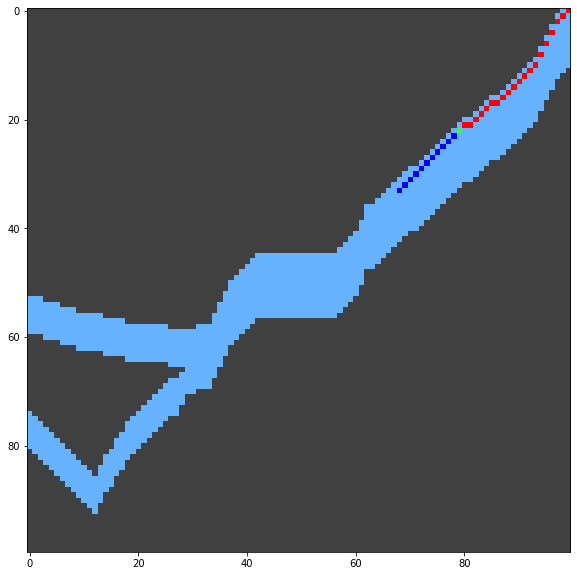

In [49]:
actual_pos = set()
pred_pos = set()
historic_pos = set()

# Get the initial positions
start_x, start_y = custom_test_motion_prediction.get_index(custom_test_motion_prediction.present_df['x'].iloc[-1], custom_test_motion_prediction.present_df['y'].iloc[-1])

# Get the predicted positions
for time_window in config['TimeWindows']:
    pred_pos.add((pred_index[time_window]))

# Get historic posisions
for idx, row in df_custom.iterrows():
    x, y = row['x'], row['y']
    index_x, index_y = custom_test_motion_prediction.get_index(x, y)
    historic_pos.add((index_x, index_y))
    
# visualize
cur_waterway = customLattice[start_y][start_x]['clusterId']
visualize_pred_custom = np.empty([config['NumRow'], config['NumCol']])
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if j == start_x and i == start_y:
            visualize_pred_custom[i][j] = 0
        elif (j,i) in pred_pos:
            visualize_pred_custom[i][j] = 3
        elif (j,i) in historic_pos:
            visualize_pred_custom[i][j] = 1
        elif customLattice[i][j]['clusterId'] == cur_waterway:
            visualize_pred_custom[i][j] = 2
        else:
            visualize_pred_custom[i][j] = 4

fig, axes = plt.subplots(1, 1, figsize=(10,10))
axes.imshow(palette[visualize_pred_custom.astype(np.int32)])

In [6]:
FilterMap = [100, 0, 100, 0]
config = {'EarthRadius': 6371000,
           'ScaleDown': 10**3,
           'VesselType': None,
           'FilterMap': FilterMap,
           'NumCol': 100,
           'NumRow': 100,
           'Increment': 1,
           'Min_x': 0,
           'Min_y': 0,
           'MinSC': 2,
           'MinNeigb': 2,
           'StoreParam': [-4, 4, 101],
           'TimeWindows': [i for i in range(1, 61)],
           'Threshold': None,
          }
        
lattice_clusters = pd.read_csv('./sample_lattice.csv').to_numpy()
customLattice = [[None] * config['NumCol'] for _ in range(config['NumRow'])]
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        customLattice[config['NumRow']-1-i][j] = {'x': config['Min_x'] + j * config['Increment'], 
                                                  'y': config['Min_y'] + i * config['Increment'], 
                                                  'code':None, 
                                                  'sampleCount': 0, 
                                                  'type/vslid': config['VesselType'], 
                                                  'label': None, 
                                                  'clusterId': None}
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if i < lattice_clusters.shape[0] and j < lattice_clusters.shape[1] and lattice_clusters[i][j] == 1.:
            customLattice[i][j]['clusterId'] = 1

x_locs = [53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33]
y_locs = [51, 51, 51, 51, 51, 51, 51, 51, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 40]
# x_locs = [53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33]
# y_locs = [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 51, 50, 49, 48, 47, 46, 44, 42, 40, 43]
df_custom = pd.DataFrame({'MMSI': [1 for _ in range(21)],
                          'x': x_locs,
                          'y': y_locs,
                          'time': [5 * i for i in range(21)],  # 0 - 100 seconds
                          'VesselType': [1 for _ in range(21)],
                          'Heading': [230 for _ in range(21)],
                          })
custom_test_motion_prediction = motion_prediction(customLattice, None, df_custom, config)
pred_PTP_ELR = custom_test_motion_prediction.forecast_trajectory()
pred_index = custom_test_motion_prediction.summarize_traj(pred_PTP_ELR)

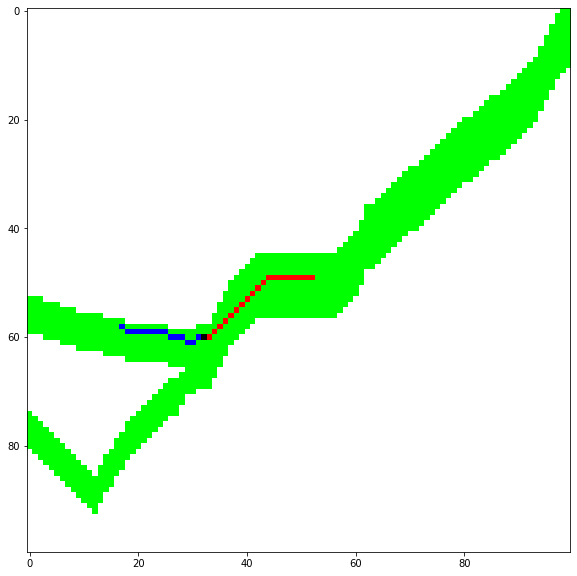

In [7]:
actual_pos = set()
pred_pos = set()
historic_pos = set()

# Get the initial positions
start_x, start_y = custom_test_motion_prediction.get_index(custom_test_motion_prediction.present_df['x'].iloc[-1], custom_test_motion_prediction.present_df['y'].iloc[-1])

# Get the predicted positions
for time_window in config['TimeWindows']:
    pred_pos.add((pred_index[time_window]))

# Get historic posisions
for idx, row in df_custom.iterrows():
    x, y = row['x'], row['y']
    index_x, index_y = custom_test_motion_prediction.get_index(x, y)
    historic_pos.add((index_x, index_y))
    
# visualize
cur_waterway = customLattice[start_y][start_x]['clusterId']
visualize_pred_custom = np.empty([config['NumRow'], config['NumCol']])
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if j == start_x and i == start_y:
            visualize_pred_custom[i][j] = 0
        elif (j,i) in pred_pos:
            visualize_pred_custom[i][j] = 3
        elif (j,i) in historic_pos:
            visualize_pred_custom[i][j] = 1
        elif customLattice[i][j]['clusterId'] == cur_waterway:
            visualize_pred_custom[i][j] = 2
        else:
            visualize_pred_custom[i][j] = 4

fig, axes = plt.subplots(1, 1, figsize=(10,10))
axes.imshow(palette[visualize_pred_custom.astype(np.int32)])

In [50]:
FilterMap = [100, 0, 100, 0]
config = {'EarthRadius': 6371000,
           'ScaleDown': 10**3,
           'VesselType': None,
           'FilterMap': FilterMap,
           'NumCol': 100,
           'NumRow': 100,
           'Increment': 1,
           'Min_x': 0,
           'Min_y': 0,
           'MinSC': 2,
           'MinNeigb': 2,
           'StoreParam': [-4, 4, 101],
           'TimeWindows': [i for i in range(1, 61)],
           'Threshold': None,
          }
        
lattice_clusters = pd.read_csv('./sample_lattice.csv').to_numpy()
customLattice = [[None] * config['NumCol'] for _ in range(config['NumRow'])]
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        customLattice[config['NumRow']-1-i][j] = {'x': config['Min_x'] + j * config['Increment'], 
                                                  'y': config['Min_y'] + i * config['Increment'], 
                                                  'code':None, 
                                                  'sampleCount': 0, 
                                                  'type/vslid': config['VesselType'], 
                                                  'label': None, 
                                                  'clusterId': None}
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if i < lattice_clusters.shape[0] and j < lattice_clusters.shape[1] and lattice_clusters[i][j] == 1.:
            customLattice[i][j]['clusterId'] = 1

x_locs = [53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 34]
y_locs = [48, 48, 48, 48, 48, 48, 48, 48, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36]
# x_locs = [53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33]
# y_locs = [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 51, 50, 49, 48, 47, 46, 44, 42, 40, 43]
df_custom = pd.DataFrame({'MMSI': [1 for _ in range(21)],
                          'x': x_locs,
                          'y': y_locs,
                          'time': [5 * i for i in range(21)],  # 0 - 100 seconds
                          'VesselType': [1 for _ in range(21)],
                          'Heading': [220 for _ in range(21)],
                          })
custom_test_motion_prediction = motion_prediction(customLattice, None, df_custom, config)
pred_PTP_ELR = custom_test_motion_prediction.forecast_trajectory()
pred_index = custom_test_motion_prediction.summarize_traj(pred_PTP_ELR)

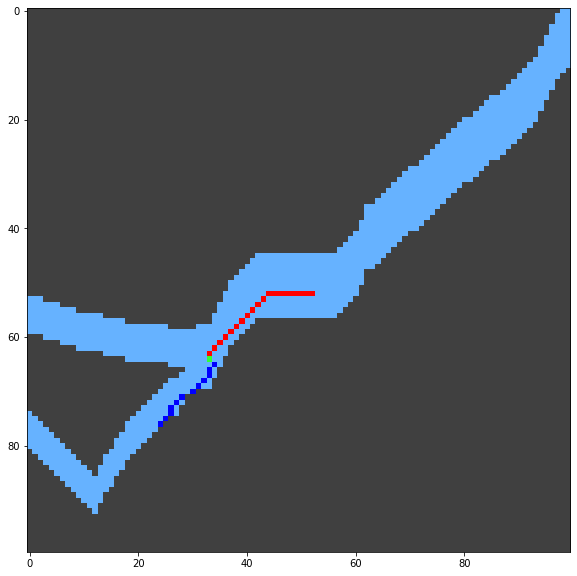

In [51]:
actual_pos = set()
pred_pos = set()
historic_pos = set()

# Get the initial positions
start_x, start_y = custom_test_motion_prediction.get_index(custom_test_motion_prediction.present_df['x'].iloc[-1], custom_test_motion_prediction.present_df['y'].iloc[-1])

# Get the predicted positions
for time_window in config['TimeWindows']:
    pred_pos.add((pred_index[time_window]))

# Get historic posisions
for idx, row in df_custom.iterrows():
    x, y = row['x'], row['y']
    index_x, index_y = custom_test_motion_prediction.get_index(x, y)
    historic_pos.add((index_x, index_y))
    
# visualize
cur_waterway = customLattice[start_y][start_x]['clusterId']
visualize_pred_custom = np.empty([config['NumRow'], config['NumCol']])
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if j == start_x and i == start_y:
            visualize_pred_custom[i][j] = 0
        elif (j,i) in pred_pos:
            visualize_pred_custom[i][j] = 3
        elif (j,i) in historic_pos:
            visualize_pred_custom[i][j] = 1
        elif customLattice[i][j]['clusterId'] == cur_waterway:
            visualize_pred_custom[i][j] = 2
        else:
            visualize_pred_custom[i][j] = 4

fig, axes = plt.subplots(1, 1, figsize=(10,10))
axes.imshow(palette[visualize_pred_custom.astype(np.int32)])

In [52]:
FilterMap = [100, 0, 100, 0]
config = {'EarthRadius': 6371000,
           'ScaleDown': 10**3,
           'VesselType': None,
           'FilterMap': FilterMap,
           'NumCol': 100,
           'NumRow': 100,
           'Increment': 1,
           'Min_x': 0,
           'Min_y': 0,
           'MinSC': 2,
           'MinNeigb': 2,
           'StoreParam': [-4, 4, 101],
           'TimeWindows': [i for i in range(1, 61)],
           'Threshold': None,
          }
        
lattice_clusters = pd.read_csv('./sample_lattice2.csv').to_numpy()
customLattice = [[None] * config['NumCol'] for _ in range(config['NumRow'])]
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        customLattice[config['NumRow']-1-i][j] = {'x': config['Min_x'] + j * config['Increment'], 
                                                  'y': config['Min_y'] + i * config['Increment'], 
                                                  'code':None, 
                                                  'sampleCount': 0, 
                                                  'type/vslid': config['VesselType'], 
                                                  'label': None, 
                                                  'clusterId': None}
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if i < lattice_clusters.shape[0] and j < lattice_clusters.shape[1] and lattice_clusters[i][j] == 1.:
            customLattice[i][j]['clusterId'] = 1

x_locs = [100, 99, 99, 98, 98, 97, 97, 96, 96, 95, 95, 94, 94, 93, 93, 92, 92, 91, 91, 90, 90]
y_locs = [61, 61, 60, 60, 59, 59, 58, 58, 57, 57, 56, 56, 55, 55, 54, 54, 53, 53, 52, 52, 51]
# x_locs = [53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33]
# y_locs = [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 51, 50, 49, 48, 47, 46, 44, 42, 40, 43]
df_custom = pd.DataFrame({'MMSI': [1 for _ in range(21)],
                          'x': x_locs,
                          'y': y_locs,
                          'time': [5 * i for i in range(21)],  # 0 - 100 seconds
                          'VesselType': [1 for _ in range(21)],
                          'Heading': [230 for _ in range(21)],
                          })
custom_test_motion_prediction = motion_prediction(customLattice, None, df_custom, config)
pred_PTP_ELR = custom_test_motion_prediction.forecast_trajectory()
pred_index = custom_test_motion_prediction.summarize_traj(pred_PTP_ELR)

Text(0, 0.5, 'y')

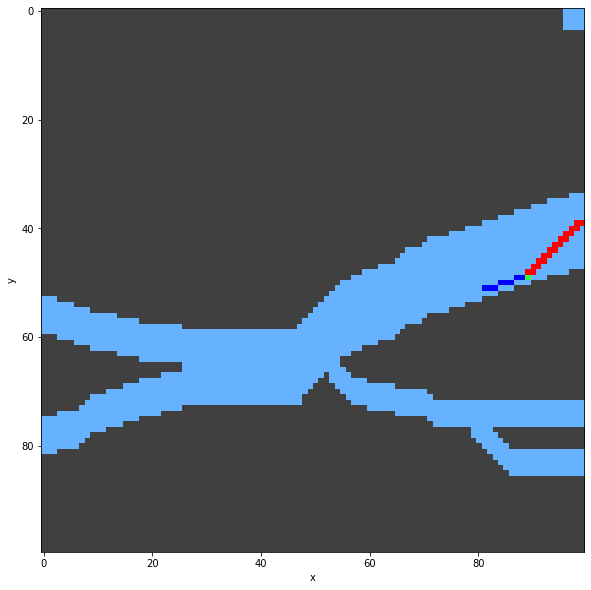

In [53]:
actual_pos = set()
pred_pos = set()
historic_pos = set()

# Get the initial positions
start_x, start_y = custom_test_motion_prediction.get_index(custom_test_motion_prediction.present_df['x'].iloc[-1], custom_test_motion_prediction.present_df['y'].iloc[-1])

# Get the predicted positions
for time_window in config['TimeWindows']:
    pred_pos.add((pred_index[time_window]))

# Get historic posisions
for idx, row in df_custom.iterrows():
    x, y = row['x'], row['y']
    index_x, index_y = custom_test_motion_prediction.get_index(x, y)
    historic_pos.add((index_x, index_y))
    
# visualize
cur_waterway = customLattice[start_y][start_x]['clusterId']
visualize_pred_custom = np.empty([config['NumRow'], config['NumCol']])
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if j == start_x and i == start_y:
            visualize_pred_custom[i][j] = 0
        elif (j,i) in pred_pos:
            visualize_pred_custom[i][j] = 3
        elif (j,i) in historic_pos:
            visualize_pred_custom[i][j] = 1
        elif customLattice[i][j]['clusterId'] == cur_waterway:
            visualize_pred_custom[i][j] = 2
        else:
            visualize_pred_custom[i][j] = 4

fig, axes = plt.subplots(1, 1, figsize=(10,10))
axes.imshow(palette[visualize_pred_custom.astype(np.int32)])
axes.set_xlabel('x')
axes.set_ylabel('y')

In [54]:
FilterMap = [100, 0, 100, 0]
config = {'EarthRadius': 6371000,
           'ScaleDown': 10**3,
           'VesselType': None,
           'FilterMap': FilterMap,
           'NumCol': 100,
           'NumRow': 100,
           'Increment': 1,
           'Min_x': 0,
           'Min_y': 0,
           'MinSC': 2,
           'MinNeigb': 2,
           'StoreParam': [-4, 4, 101],
           'TimeWindows': [i for i in range(1, 61)],
           'Threshold': None,
          }
        
lattice_clusters = pd.read_csv('./sample_lattice2.csv').to_numpy()
customLattice = [[None] * config['NumCol'] for _ in range(config['NumRow'])]
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        customLattice[config['NumRow']-1-i][j] = {'x': config['Min_x'] + j * config['Increment'], 
                                                  'y': config['Min_y'] + i * config['Increment'], 
                                                  'code':None, 
                                                  'sampleCount': 0, 
                                                  'type/vslid': config['VesselType'], 
                                                  'label': None, 
                                                  'clusterId': None}
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if i < lattice_clusters.shape[0] and j < lattice_clusters.shape[1] and lattice_clusters[i][j] == 1.:
            customLattice[i][j]['clusterId'] = 1

x_locs = [100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80]
y_locs = [61, 61, 61, 60, 60, 60, 59, 59, 59, 58, 58, 58, 57, 57, 57, 56, 56, 56, 55, 55, 55]
# x_locs = [53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33]
# y_locs = [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 51, 50, 49, 48, 47, 46, 44, 42, 40, 43]
df_custom = pd.DataFrame({'MMSI': [1 for _ in range(21)],
                          'x': x_locs,
                          'y': y_locs,
                          'time': [5 * i for i in range(21)],  # 0 - 100 seconds
                          'VesselType': [1 for _ in range(21)],
                          'Heading': [250 for _ in range(21)],
                          })
custom_test_motion_prediction = motion_prediction(customLattice, None, df_custom, config)
pred_PTP_ELR = custom_test_motion_prediction.forecast_trajectory()
pred_index = custom_test_motion_prediction.summarize_traj(pred_PTP_ELR)

Text(0, 0.5, 'y')

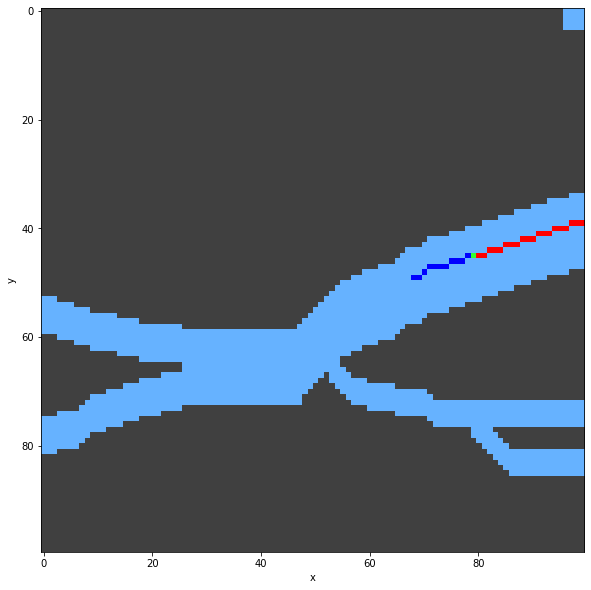

In [55]:
actual_pos = set()
pred_pos = set()
historic_pos = set()

# Get the initial positions
start_x, start_y = custom_test_motion_prediction.get_index(custom_test_motion_prediction.present_df['x'].iloc[-1], custom_test_motion_prediction.present_df['y'].iloc[-1])

# Get the predicted positions
for time_window in config['TimeWindows']:
    pred_pos.add((pred_index[time_window]))

# Get historic posisions
for idx, row in df_custom.iterrows():
    x, y = row['x'], row['y']
    index_x, index_y = custom_test_motion_prediction.get_index(x, y)
    historic_pos.add((index_x, index_y))
    
# visualize
cur_waterway = customLattice[start_y][start_x]['clusterId']
visualize_pred_custom = np.empty([config['NumRow'], config['NumCol']])
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if j == start_x and i == start_y:
            visualize_pred_custom[i][j] = 0
        elif (j,i) in pred_pos:
            visualize_pred_custom[i][j] = 3
        elif (j,i) in historic_pos:
            visualize_pred_custom[i][j] = 1
        elif customLattice[i][j]['clusterId'] == cur_waterway:
            visualize_pred_custom[i][j] = 2
        else:
            visualize_pred_custom[i][j] = 4

fig, axes = plt.subplots(1, 1, figsize=(10,10))
axes.imshow(palette[visualize_pred_custom.astype(np.int32)])
axes.set_xlabel('x')
axes.set_ylabel('y')

In [56]:
FilterMap = [100, 0, 100, 0]
config = {'EarthRadius': 6371000,
           'ScaleDown': 10**3,
           'VesselType': None,
           'FilterMap': FilterMap,
           'NumCol': 100,
           'NumRow': 100,
           'Increment': 1,
           'Min_x': 0,
           'Min_y': 0,
           'MinSC': 2,
           'MinNeigb': 2,
           'StoreParam': [-4, 4, 101],
           'TimeWindows': [i for i in range(1, 61)],
           'Threshold': None,
          }
        
lattice_clusters = pd.read_csv('./sample_lattice2.csv').to_numpy()
customLattice = [[None] * config['NumCol'] for _ in range(config['NumRow'])]
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        customLattice[config['NumRow']-1-i][j] = {'x': config['Min_x'] + j * config['Increment'], 
                                                  'y': config['Min_y'] + i * config['Increment'], 
                                                  'code':None, 
                                                  'sampleCount': 0, 
                                                  'type/vslid': config['VesselType'], 
                                                  'label': None, 
                                                  'clusterId': None}
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if i < lattice_clusters.shape[0] and j < lattice_clusters.shape[1] and lattice_clusters[i][j] == 1.:
            customLattice[i][j]['clusterId'] = 1

x_locs = [50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30]
# y_locs = [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
y_locs = [38] * 21
# x_locs = [53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33]
# y_locs = [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 51, 50, 49, 48, 47, 46, 44, 42, 40, 43]
df_custom = pd.DataFrame({'MMSI': [1 for _ in range(21)],
                          'x': x_locs,
                          'y': y_locs,
                          'time': [5 * i for i in range(21)],  # 0 - 100 seconds
                          'VesselType': [1 for _ in range(21)],
                          'Heading': [250 for _ in range(21)],
                          })
custom_test_motion_prediction = motion_prediction(customLattice, None, df_custom, config)
pred_PTP_ELR = custom_test_motion_prediction.forecast_trajectory()
pred_index = custom_test_motion_prediction.summarize_traj(pred_PTP_ELR)

Text(0, 0.5, 'y')

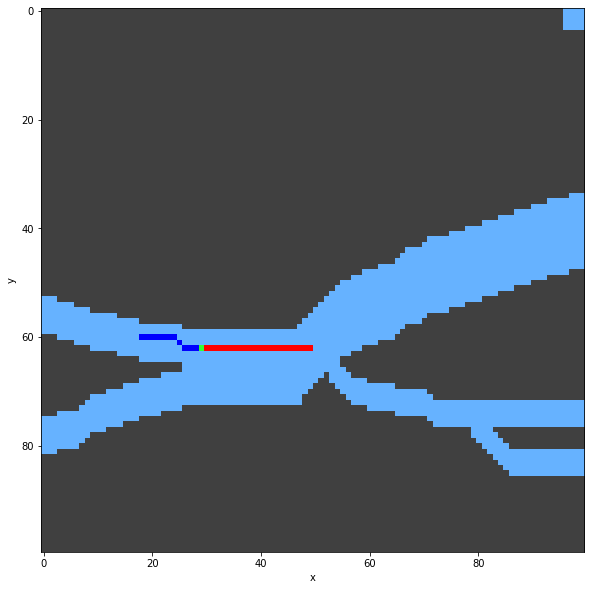

In [57]:
actual_pos = set()
pred_pos = set()
historic_pos = set()

# Get the initial positions
start_x, start_y = custom_test_motion_prediction.get_index(custom_test_motion_prediction.present_df['x'].iloc[-1], custom_test_motion_prediction.present_df['y'].iloc[-1])

# Get the predicted positions
for time_window in config['TimeWindows']:
    pred_pos.add((pred_index[time_window]))

# Get historic posisions
for idx, row in df_custom.iterrows():
    x, y = row['x'], row['y']
    index_x, index_y = custom_test_motion_prediction.get_index(x, y)
    historic_pos.add((index_x, index_y))
    
# visualize
cur_waterway = customLattice[start_y][start_x]['clusterId']
visualize_pred_custom = np.empty([config['NumRow'], config['NumCol']])
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if j == start_x and i == start_y:
            visualize_pred_custom[i][j] = 0
        elif (j,i) in pred_pos:
            visualize_pred_custom[i][j] = 3
        elif (j,i) in historic_pos:
            visualize_pred_custom[i][j] = 1
        elif customLattice[i][j]['clusterId'] == cur_waterway:
            visualize_pred_custom[i][j] = 2
        else:
            visualize_pred_custom[i][j] = 4

fig, axes = plt.subplots(1, 1, figsize=(10,10))
axes.imshow(palette[visualize_pred_custom.astype(np.int32)])
axes.set_xlabel('x')
axes.set_ylabel('y')

In [58]:
FilterMap = [100, 0, 100, 0]
config = {'EarthRadius': 6371000,
           'ScaleDown': 10**3,
           'VesselType': None,
           'FilterMap': FilterMap,
           'NumCol': 100,
           'NumRow': 100,
           'Increment': 1,
           'Min_x': 0,
           'Min_y': 0,
           'MinSC': 2,
           'MinNeigb': 2,
           'StoreParam': [-4, 4, 101],
           'TimeWindows': [i for i in range(1, 61)],
           'Threshold': None,
          }
        
lattice_clusters = pd.read_csv('./sample_lattice2.csv').to_numpy()
customLattice = [[None] * config['NumCol'] for _ in range(config['NumRow'])]
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        customLattice[config['NumRow']-1-i][j] = {'x': config['Min_x'] + j * config['Increment'], 
                                                  'y': config['Min_y'] + i * config['Increment'], 
                                                  'code':None, 
                                                  'sampleCount': 0, 
                                                  'type/vslid': config['VesselType'], 
                                                  'label': None, 
                                                  'clusterId': None}
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if i < lattice_clusters.shape[0] and j < lattice_clusters.shape[1] and lattice_clusters[i][j] == 1.:
            customLattice[i][j]['clusterId'] = 1

x_locs = [50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30]
# y_locs = [36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
y_locs = [34,33,32,31] + [30] * 17
# x_locs = [53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33]
# y_locs = [52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 51, 50, 49, 48, 47, 46, 44, 42, 40, 43]
df_custom = pd.DataFrame({'MMSI': [1 for _ in range(21)],
                          'x': x_locs,
                          'y': y_locs,
                          'time': [5 * i for i in range(21)],  # 0 - 100 seconds
                          'VesselType': [1 for _ in range(21)],
                          'Heading': [250 for _ in range(21)],
                          })
custom_test_motion_prediction = motion_prediction(customLattice, None, df_custom, config)
pred_PTP_ELR = custom_test_motion_prediction.forecast_trajectory()
pred_index = custom_test_motion_prediction.summarize_traj(pred_PTP_ELR)

Text(0, 0.5, 'y')

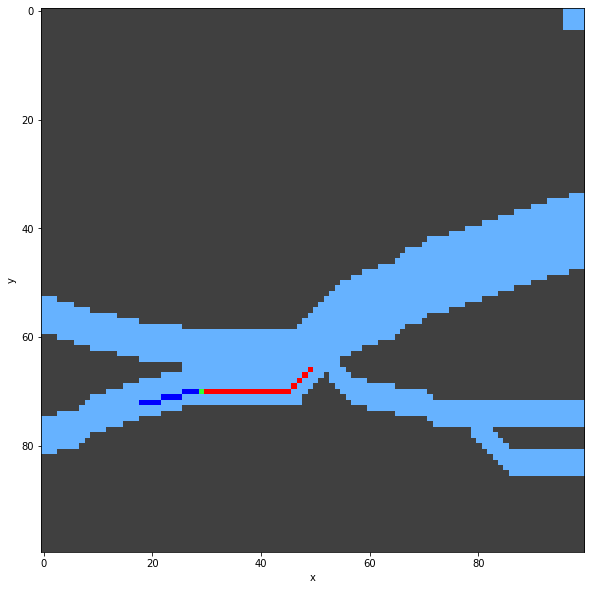

In [59]:
actual_pos = set()
pred_pos = set()
historic_pos = set()

# Get the initial positions
start_x, start_y = custom_test_motion_prediction.get_index(custom_test_motion_prediction.present_df['x'].iloc[-1], custom_test_motion_prediction.present_df['y'].iloc[-1])

# Get the predicted positions
for time_window in config['TimeWindows']:
    pred_pos.add((pred_index[time_window]))

# Get historic posisions
for idx, row in df_custom.iterrows():
    x, y = row['x'], row['y']
    index_x, index_y = custom_test_motion_prediction.get_index(x, y)
    historic_pos.add((index_x, index_y))
    
# visualize
cur_waterway = customLattice[start_y][start_x]['clusterId']
visualize_pred_custom = np.empty([config['NumRow'], config['NumCol']])
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if j == start_x and i == start_y:
            visualize_pred_custom[i][j] = 0
        elif (j,i) in pred_pos:
            visualize_pred_custom[i][j] = 3
        elif (j,i) in historic_pos:
            visualize_pred_custom[i][j] = 1
        elif customLattice[i][j]['clusterId'] == cur_waterway:
            visualize_pred_custom[i][j] = 2
        else:
            visualize_pred_custom[i][j] = 4

fig, axes = plt.subplots(1, 1, figsize=(10,10))
axes.imshow(palette[visualize_pred_custom.astype(np.int32)])
axes.set_xlabel('x')
axes.set_ylabel('y')

In [81]:
FilterMap = [100, 0, 100, 0]
config = {'EarthRadius': 6371000,
           'ScaleDown': 10**3,
           'VesselType': None,
           'FilterMap': FilterMap,
           'NumCol': 100,
           'NumRow': 100,
           'Increment': 1,
           'Min_x': 0,
           'Min_y': 0,
           'MinSC': 2,
           'MinNeigb': 2,
           'StoreParam': [-4, 4, 101],
           'TimeWindows': [i for i in range(1, 61)],
           'Threshold': None,
          }
        
lattice_clusters = pd.read_csv('./sample_lattice2.csv').to_numpy()
customLattice = [[None] * config['NumCol'] for _ in range(config['NumRow'])]
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        customLattice[config['NumRow']-1-i][j] = {'x': config['Min_x'] + j * config['Increment'], 
                                                  'y': config['Min_y'] + i * config['Increment'], 
                                                  'code':None, 
                                                  'sampleCount': 0, 
                                                  'type/vslid': config['VesselType'], 
                                                  'label': None, 
                                                  'clusterId': None}
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if i < lattice_clusters.shape[0] and j < lattice_clusters.shape[1] and lattice_clusters[i][j] == 1.:
            customLattice[i][j]['clusterId'] = 1

x_locs = [i for i in reversed(range(54, 74))] + [54]
y_locs = [36]
for i in range(10):
    y_locs = [i+37, i+37] + y_locs
# y_locs = [49, 49, 48, 48, 47, 47, 46, 46, 45, 45, 44, 44, 43, 43, 42, 42, 41, 41, 40, 40, 39]
# y_locs = [i for i in reversed(range(38, 59))]
# y_locs = [34,33,32,31] + [30] * 17

df_custom = pd.DataFrame({'MMSI': [1 for _ in range(21)],
                          'x': x_locs,
                          'y': y_locs,
                          'time': [5 * i for i in range(21)],  # 0 - 100 seconds
                          'VesselType': [1 for _ in range(21)],
                          'Heading': [180 for _ in range(21)],
                          })
custom_test_motion_prediction = motion_prediction(customLattice, None, df_custom, config)
pred_PTP_ELR = custom_test_motion_prediction.forecast_trajectory()
pred_index = custom_test_motion_prediction.summarize_traj(pred_PTP_ELR)

Text(0, 0.5, 'y')

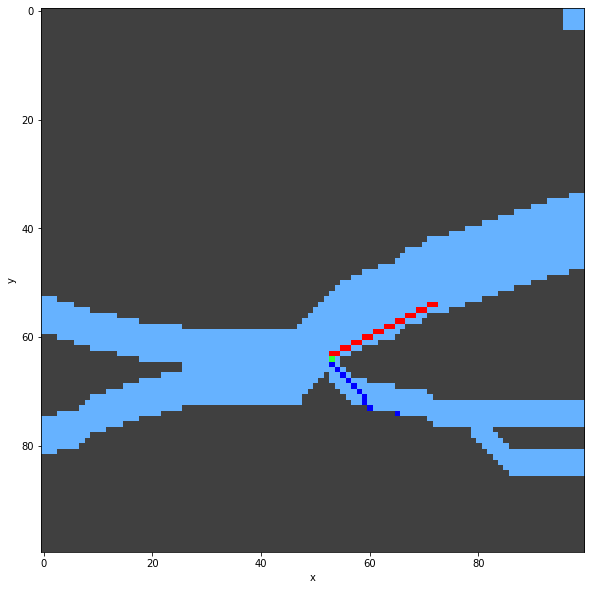

In [82]:
actual_pos = set()
pred_pos = set()
historic_pos = set()

# Get the initial positions
start_x, start_y = custom_test_motion_prediction.get_index(custom_test_motion_prediction.present_df['x'].iloc[-1], custom_test_motion_prediction.present_df['y'].iloc[-1])

# Get the predicted positions
for time_window in config['TimeWindows']:
    pred_pos.add((pred_index[time_window]))

# Get historic posisions
for idx, row in df_custom.iterrows():
    x, y = row['x'], row['y']
    index_x, index_y = custom_test_motion_prediction.get_index(x, y)
    historic_pos.add((index_x, index_y))
    
# visualize
cur_waterway = customLattice[start_y][start_x]['clusterId']
visualize_pred_custom = np.empty([config['NumRow'], config['NumCol']])
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if j == start_x and i == start_y:
            visualize_pred_custom[i][j] = 0
        elif (j,i) in pred_pos:
            visualize_pred_custom[i][j] = 3
        elif (j,i) in historic_pos:
            visualize_pred_custom[i][j] = 1
        elif customLattice[i][j]['clusterId'] == cur_waterway:
            visualize_pred_custom[i][j] = 2
        else:
            visualize_pred_custom[i][j] = 4

fig, axes = plt.subplots(1, 1, figsize=(10,10))
axes.imshow(palette[visualize_pred_custom.astype(np.int32)])
axes.set_xlabel('x')
axes.set_ylabel('y')

In [88]:
FilterMap = [100, 0, 100, 0]
config = {'EarthRadius': 6371000,
           'ScaleDown': 10**3,
           'VesselType': None,
           'FilterMap': FilterMap,
           'NumCol': 100,
           'NumRow': 100,
           'Increment': 1,
           'Min_x': 0,
           'Min_y': 0,
           'MinSC': 2,
           'MinNeigb': 2,
           'StoreParam': [-4, 4, 101],
           'TimeWindows': [i for i in range(1, 61)],
           'Threshold': None,
          }
        
lattice_clusters = pd.read_csv('./sample_lattice2.csv').to_numpy()
customLattice = [[None] * config['NumCol'] for _ in range(config['NumRow'])]
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        customLattice[config['NumRow']-1-i][j] = {'x': config['Min_x'] + j * config['Increment'], 
                                                  'y': config['Min_y'] + i * config['Increment'], 
                                                  'code':None, 
                                                  'sampleCount': 0, 
                                                  'type/vslid': config['VesselType'], 
                                                  'label': None, 
                                                  'clusterId': None}
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if i < lattice_clusters.shape[0] and j < lattice_clusters.shape[1] and lattice_clusters[i][j] == 1.:
            customLattice[i][j]['clusterId'] = 1

x_locs = [i for i in reversed(range(55, 75))] + [54]
y_locs = [36]
for i in range(10):
    y_locs = [i+37, i+37] + y_locs
# y_locs = [49, 49, 48, 48, 47, 47, 46, 46, 45, 45, 44, 44, 43, 43, 42, 42, 41, 41, 40, 40, 39]
# y_locs = [i for i in reversed(range(38, 59))]
# y_locs = [34,33,32,31] + [30] * 17

df_custom = pd.DataFrame({'MMSI': [1 for _ in range(21)],
                          'x': x_locs,
                          'y': y_locs,
                          'time': [5 * i for i in range(21)],  # 0 - 100 seconds
                          'VesselType': [1 for _ in range(21)],
                          'Heading': [230 for _ in range(21)],
                          })
custom_test_motion_prediction = motion_prediction(customLattice, None, df_custom, config)
pred_PTP_ELR = custom_test_motion_prediction.forecast_trajectory()
pred_index = custom_test_motion_prediction.summarize_traj(pred_PTP_ELR)

Text(0, 0.5, 'y')

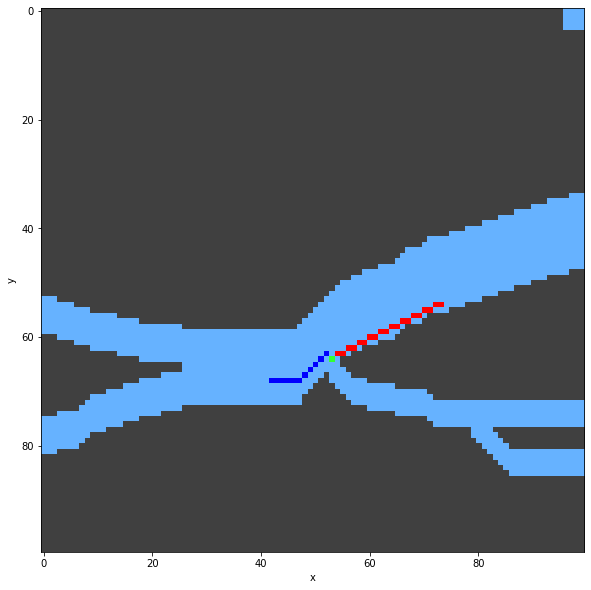

In [89]:
actual_pos = set()
pred_pos = set()
historic_pos = set()

# Get the initial positions
start_x, start_y = custom_test_motion_prediction.get_index(custom_test_motion_prediction.present_df['x'].iloc[-1], custom_test_motion_prediction.present_df['y'].iloc[-1])

# Get the predicted positions
for time_window in config['TimeWindows']:
    pred_pos.add((pred_index[time_window]))

# Get historic posisions
for idx, row in df_custom.iterrows():
    x, y = row['x'], row['y']
    index_x, index_y = custom_test_motion_prediction.get_index(x, y)
    historic_pos.add((index_x, index_y))
    
# visualize
cur_waterway = customLattice[start_y][start_x]['clusterId']
visualize_pred_custom = np.empty([config['NumRow'], config['NumCol']])
for i in range(config['NumRow']):
    for j in range(config['NumCol']):
        if j == start_x and i == start_y:
            visualize_pred_custom[i][j] = 0
        elif (j,i) in pred_pos:
            visualize_pred_custom[i][j] = 3
        elif (j,i) in historic_pos:
            visualize_pred_custom[i][j] = 1
        elif customLattice[i][j]['clusterId'] == cur_waterway:
            visualize_pred_custom[i][j] = 2
        else:
            visualize_pred_custom[i][j] = 4

fig, axes = plt.subplots(1, 1, figsize=(10,10))
axes.imshow(palette[visualize_pred_custom.astype(np.int32)])
axes.set_xlabel('x')
axes.set_ylabel('y')